In [29]:
from typing import Tuple

class Trolley:
	def __init__(self, mass: float, friction: float, dt: float) -> None:
		"""
		Initialize the trolley

		Args:
			mass (float): mass of the trolley
			friction (float): friction coefficient of the trolley
			dt (float): time step between the current and previous position

		Returns:
			None
		"""
		self.mass: float = mass # kg
		self.friction: float = friction # N*s/m
		self.spring_constant: float = 50 # N/m
		self.dt: float = dt # s
		self.position: float = 0 # m
		self.delta_position: float = 0
		self.velocity: float = 0 # m/s
		self.F: float = 50 # N


	def update(self, control_output: float, distrubance: float = 0) -> None:
		"""
		Update the position and velocity of the trolley
		
		Args:
			TODO: select best unit for the demonstration
		
		Returns:
			None
			
		Equation of model:
            F = ma
            a = F/m
            a = F/m - friction*v/m
            v = v + a*dt
            x = x + v*dt
		"""
		F = control_output
		acceleration = F / self.mass - self.friction * self.velocity / self.mass - self.spring_constant * self.delta_position / self.mass
		self.velocity += acceleration * self.dt
		position = self.position + self.velocity * self.dt
		self.delta_position = position - self.position
		self.position = position


	def get_position(self) -> float:
		"""
		Get the position of the trolley

		Args:
			None

		Returns:
			float: position of the trolley
		"""
		return self.position
	

	def get_U(self) -> Tuple[float, float, float]:
		return self.position, self.position/self.dt, self.position/(self.dt**2)
	

class PID:
	"""PID controller class"""
	def __init__(self, KP: float, KI: float, KD: float) -> None:
		"""
		A PID controller is characterized by three parameters: proportional gain (KP), integral gain (KI), and derivative gain (KD).
		
		Args:
            KP (float): proportional gain
            KI (float): integral gain
            KD (float): derivative gain
		"""
		# PID parameters
		self.KP: float = KP
		self.KI: float = KI
		self.KD: float = KD	

        # PID states
		self.error: float = 0
		self.error_last: float = 0
		self.integral_error: float = 0
		self.derivative_error: float = 0

		# PID saturation limits
		self.saturation_max: float = 5
		self.saturation_min: float = -5
	
    
	def compute(self, target: float, position: float, dt: float) -> float:
		"""
		Calculate the output of the PID controller
		
		Args:
            target (float): target value
			position (float): current value
			dt (float): time step between the current and previous position
			
        Returns:
            float: output of the PID controller
		"""
		# Calculate the errors
		self.error = target - position # error = target - current
		self.integral_error += self.error * dt #error build up over time
		self.derivative_error = (self.error - self.error_last) / dt #find the derivative of the error (how the error changes with time)
		self.error_last = self.error # update the error
		
		# Calculate the output
		output = \
			self.KP * self.error + \
			self.KI * self.integral_error + \
			self.KD * self.derivative_error

		if output > self.saturation_max and self.saturation_max:
			output = self.saturation_max
		elif output < self.saturation_min and self.saturation_min:
			output = self.saturation_min
		return output


	def setLims(self, min: float, max: float) -> None:
		"""
		Set the saturation limits for the PID controller
		
		Args:
            min (float): minimum value of the output
            max (float): maximum value of the output
			
        Returns:
            None
		"""
		self.saturation_max = max
		self.saturation_min = min


In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Defining the architecture of the neural network
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(4, 8)
        self.norm1 = nn.BatchNorm1d(8)
        self.fc2 = nn.Linear(8, 3)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return x

# Custom Loss Function
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, predicted_Y, input_X, error, dt):
        """
        Args:
            predicted_Y (tensor): coeeficients of the PID controller (KP, KI, KD)
            input_X (tensor): X(t) = [x(t), x(t-1), u(t), u(t-1)]
            error (tensor): error between the target and current position
            dt (float): time step between the current and previous position

        Returns:
            loss (tensor): loss function
        """
        x_t = input_X[0]
        x_t_1 = input_X[1]
        u_t = input_X[2]
        u_t_1 = input_X[3]
        error = torch.tensor(np.float64(error))

        dxdt = (x_t_1 - x_t) / dt
        dudt = (u_t_1 - u_t) / dt

        mse_loss = torch.mean(error**2)
        control_loss = torch.mean((u_t_1-u_t)**2)
        loss = mse_loss + control_loss

        # loss = torch.mean((dxdt)**2)
        return loss


In [31]:
# Creating the model, loss function and optimizer
model = NeuralNetwork()
custom_loss = CustomLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [32]:
import numpy as np
from numpy.typing import NDArray
from simulation import Simulation
import matplotlib.pyplot as plt

class SimulationNN(Simulation):
	def __init__(self, time: NDArray, target: NDArray, disturbance: NDArray, dt: float = 0.01) -> None:
		super().__init__(time, target, disturbance, dt)
		self.model = None
		self.custom_loss = None
		self.optimizer = None

		self.feedback_U = np.zeros(len(time))
		self.feedback_Kp = np.zeros(len(time))
		self.feedback_Ki = np.zeros(len(time))
		self.feedback_Kd = np.zeros(len(time))


	def run(self, trolley: Trolley, pid: PID) -> None:

		# Check if the model, loss function, and optimizer are defined
		if self.model is None or self.custom_loss is None or self.optimizer is None:
			raise Exception("Model, loss function, or optimizer is not defined")

		# This cycle like the one epoc in the training
		for i in range(1, len(self.time)):
			# Get data from the previous step
			target = self.target[i]
			disturbance = self.disturbance[i]
			position = trolley.get_position()

			# PID controller
			pid.KP = self.feedback_Kp[i-1]
			pid.KI = self.feedback_Ki[i-1]
			pid.KD = self.feedback_Kd[i-1]
			control_output = pid.compute(target, position, self.dt)
			self.feedback_U[i] = control_output

			# Update the trolley
			trolley.update(control_output, disturbance)

			# Get the current position
			new_position = trolley.get_position()
			self.feedback_X[i] = new_position

			# Reset gradient
			self.optimizer.zero_grad()

			# Build input vector X
			X_t = self.feedback_X[i]
			X_t_1 = self.feedback_X[i-1]
			U_t = self.feedback_U[i]
			U_t_1 = self.feedback_U[i-1]
			input_X = torch.tensor([X_t, X_t_1, U_t, U_t_1], dtype=torch.float32, requires_grad=True)

			# Predict the next coeeficients of the PID controller
			predicted_Y = self.model(input_X)
			Kp = predicted_Y[0].item()
			Ki = predicted_Y[1].item()
			Kd = predicted_Y[2].item()

			# Save the coefficients
			self.feedback_Kp[i] = Kp
			self.feedback_Ki[i] = Ki
			self.feedback_Kd[i] = Kd

			# Calculate the loss
			error = target - new_position
			loss = self.custom_loss(predicted_Y, input_X, error, self.dt)

			# Backpropagation
			# loss.backward()

			# Update the weights
			self.optimizer.step()


	def plot_K(self) -> None:
		# Plot the coefficients
		fig, ax = plt.subplots(1, 3, figsize=(15, 5))
		ax[0].plot(self.time, self.feedback_Kp, label='Kp')
		ax[0].set_xlabel('Time [s]')
		ax[0].set_ylabel('Kp')
		ax[0].legend()
		ax[1].plot(self.time, self.feedback_Ki, label='Ki')
		ax[1].set_xlabel('Time [s]')
		ax[1].set_ylabel('Ki')
		ax[1].legend()
		ax[2].plot(self.time, self.feedback_Kd, label='Kd')
		ax[2].set_xlabel('Time [s]')
		ax[2].set_ylabel('Kd')
		ax[2].legend()
		plt.show()



In [42]:
from re import T


DT = 0.01
TIME = np.arange(0, 300, DT)
TARGET = np.zeros(len(TIME)) * 5
DISTURBANCE = np.zeros(len(TIME))

trolley = Trolley(1, 0.1, DT)
pid = PID(0, 0, 0)
simulation = SimulationNN(TIME, TARGET, DISTURBANCE, DT)
simulation.model = model
simulation.custom_loss = custom_loss
simulation.optimizer = optimizer

EPOCHS = 5

for i in range(EPOCHS):
    print(f"Epoch {i+1}/{EPOCHS}")

    TARGET = np.ones(len(TIME)) * np.random.uniform(0, 5)
    TARGET[TIME > 50] = np.random.uniform(0, 5)
    TARGET[TIME > 100] = np.random.uniform(0, 5)
    TARGET[TIME > 150] = np.random.uniform(0, 5)
    TARGET[TIME > 200] = np.random.uniform(0, 5)
    TARGET[TIME > 250] = np.random.uniform(0, 5)

    simulation.target = TARGET
    simulation.run(trolley, pid)

Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5


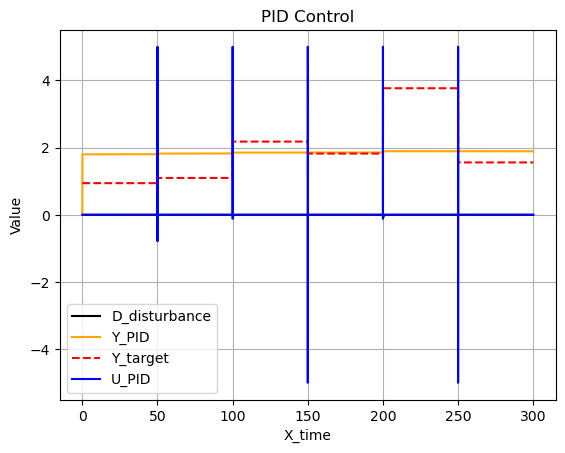

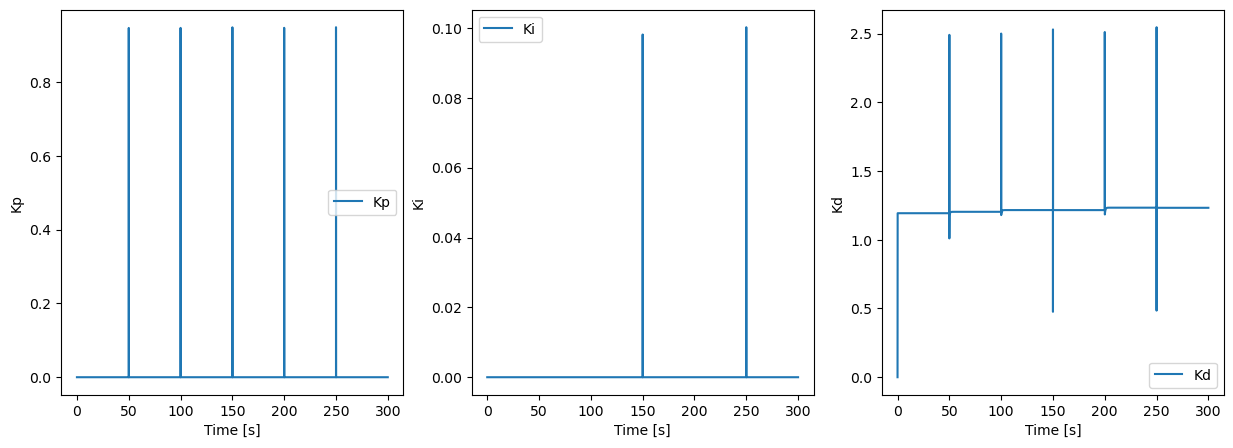

In [43]:
simulation.plot()
simulation.plot_K()

In [39]:
simulation.target

array([0., 0., 0., ..., 0., 0., 0.])